In [66]:
# Importing packages 

import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

import nltk 

#You may need to download the following to run this code: 

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer # Porter is used below. This is an alternative, harsher stemmer. 
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

from collections import defaultdict

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jrk504/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jrk504/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jrk504/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jrk504/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Advanced Social Data Science 2 (ASDS2) Exercises


## April 21: Preprocessing

### 1: Importing data without preprocessing

1. Download the data set available here, which contains the nearly 6,000 times Donald Trump insulted someone on Twitter: https://www.kaggle.com/ayushggarg/all-trumps-twitter-insults-20152021 
2. Load the csv as a data frame using pandas.

In [30]:
trump = pd.read_csv('trump_insult_tweets_2014_to_2021.csv', index_col = 0)

In [31]:
trump.head()

,date,target,insult,tweet
1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ..."
3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...
4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...
5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily..."


3. The variable ‘target’ has an indicator for the target of the insult. The data reveals that Trump’s most frequent insult target is ‘the media’ (‘the-media’ in the data). Create a binary indicator for whether Trump targets the media. Fit a linear regression with this binary indicator as the dependent variable and the date of the tweet as the independent variable. Does Trump become more or less likely to insult the media over time? Why might this be? 

In [32]:
#Using value counts to see that Trump's most frequent insult target is the media
trump['target'].value_counts()

target
the-media                  1287
democrats                   647
hillary-clinton             625
trump-russia                441
joe-biden                   402
                           ... 
mccabe-memos                  1
state-department              1
us-mexico-trade-surplus       1
us-court-system               1
mike-pence                    1
Name: count, Length: 866, dtype: int64

In [33]:
#Creating a column with a binary indicator for whether the media is targeted in a given tweet
trump['media'] = (trump['target'] == 'the-media').astype(int)

In [34]:
#Date is str type, which we cannot use. Correcting date to datetime type
trump['date'] = pd.to_datetime(trump['date'], format = '%Y-%m-%d', errors = 'ignore')

#make dates regression appropriate:
trump['date_ordinal'] = trump['date'].map(dt.datetime.toordinal) #makes each Y-M-D a unique number (starting from some random number)
trump['date_from_0'] =  trump['date_ordinal'] - min(trump['date_ordinal']) #Makes each data a number starting from 0 to the number of days since the first tweet

First let's try and fit the model with a Linear regression. Given the binary outcome variable this is probably not the most appropriate thing to do

In [55]:
#Create the feature and target vectors
#X = trump['date'].values.reshape(-1, 1)
X = trump['date_from_0'].values.reshape(-1, 1)

y = trump['media'].values

#Creating and fitting a linear regression model
model = LinearRegression()
model.fit(X,y)

#Viewing the computed linear regression coefficient to determine whether Trump becomes more or less likely to insult the media over time
print(model.coef_[0])


4.3098811591001747e-05


The coefficient is slightly positive, showing that Trump becomes more likely to insult the media over time. Maybe he is getting more negative media attention because of his insults as time progresses and then he retaliates by insulting the media.

Now let's try the more appropriate option of using a Logistic regression

Log-odds daily increase 0.0004156666563803
Odds factor increase 1.0004157530577358


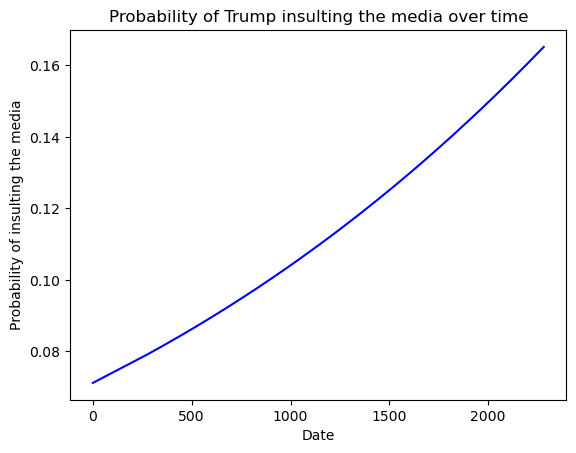

In [74]:
#Creating and fitting a linear regression model
model = LogisticRegression(penalty = None)
model.fit(X,y)

#Viewing the computed linear regression coefficient to determine whether Trump becomes more or less likely to insult the media over time
print(f"Log-odds daily increase {model.coef_[0][0]}")
print(f"Odds factor increase {np.exp(model.coef_[0][0])}")

#Plot the likelihood of Trump insulting the media over time
plt.plot(X, model.predict_proba(X)[:,1], color = 'blue')
plt.xlabel('Date')
plt.ylabel('Probability of insulting the media')
plt.title('Probability of Trump insulting the media over time')
plt.show()

What do the coeffcients of our logistic regression mean? It means that every day the log-odds of Trump tweeting an insult increases by 0.0042. This value indicates that each additional day increases the odds of Trump insulting by a factor of approximately 1.000416

4. Using the CountVectorizer from sklearn, convert the tweets to a document-feature matrix. What are the dimensions of the matrix?

In [69]:
#Creating and fitting a vectorizer to convert the tweets to a document-feature matrix
vectorizer = CountVectorizer(lowercase=False, ngram_range=(1,1), analyzer = "word")

matrix = vectorizer.fit_transform(trump['tweet'])

#Viewing the matrix dimensions
matrix.shape


(10360, 12902)

The matrix has 10360 rows and 12902 columns. This means that we have 10360 tweets described by counts of 12902 unique words (features)

In [37]:
#If you are interested, you can see the bag of words as identified by the vectorizer by uncommenting below
#vectorizer.get_feature_names()


### 2: Preprocessing steps

1. Remove all tagged users, i.e. words starting with the ‘@’ character.
2. Lowercase all tweet text.
3. Remove numbers.
4. Remove extra whitespace.
5. Remove default stopwords.
6. Remove punctuation. 
7. Stem words.
8. Lemmatize words. (Hint: lemmatization requires part-of-speech tags)

A couple of hints:
The NLTK library has a stemmer and a lemmatizer, and other helpful lexical resources. 

The text (string objects) in a dataframe column can be accessed using .str (eg. df.text_col.str) see here https://pandas.pydata.org/docs/user_guide/text.html#string-methods 

For some steps it is a good idea to define a function that works on single string and then use the *apply* method from pandas 


In [38]:
#Remove all tagged users, i.e. words starting with the ‘@’ character.
trump['tweet_no_tags'] = trump['tweet'].str.replace(r'@\w+ ', '', regex = True)
    #Notice that there may be issues: If Trump mistakenly put a space after @ (e.g. '@ CBS' in index 576) the tag is not removed

#Lowercase all tweet text
trump['tweet_lowercase'] = trump['tweet_no_tags'].str.lower()

#Remove numbers 
trump['tweet_no_numbers'] = trump['tweet_lowercase'].str.replace(r'\d+', '', regex = True)

#Remove whitespace (a two stage removal process is required to remove all whitespace)
trump['tweet_no_whitespace'] = trump['tweet_no_numbers'].str.replace(r'\s+', ' ', regex = True) #replace all whitespace with a single space
trump['tweet_no_whitespace'] = trump['tweet_no_whitespace'].str.strip() #removes whitespace at the beginning and end of the string


In [39]:
#Viewing preprocesing steps so far
trump.head()

,date,target,insult,tweet,media,date_ordinal,date_from_0,tweet_no_tags,tweet_lowercase,tweet_no_numbers,tweet_no_whitespace
1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ...",0,735515,0,"Can you believe this fool, Dr. Thomas Frieden ...","can you believe this fool, dr. thomas frieden ...","can you believe this fool, dr. thomas frieden ...","can you believe this fool, dr. thomas frieden ..."
2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ...",0,735515,0,"Can you believe this fool, Dr. Thomas Frieden ...","can you believe this fool, dr. thomas frieden ...","can you believe this fool, dr. thomas frieden ...","can you believe this fool, dr. thomas frieden ..."
3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...,0,735765,250,Big time in U.S. today - MAKE AMERICA GREAT AG...,big time in u.s. today - make america great ag...,big time in u.s. today - make america great ag...,big time in u.s. today - make america great ag...
4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...,0,735773,258,Politician didn't like that I said Baltimore n...,politician didn't like that i said baltimore n...,politician didn't like that i said baltimore n...,politician didn't like that i said baltimore n...
5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily...",0,735773,258,"For the nonbeliever, here is a photo of in my ...","for the nonbeliever, here is a photo of in my ...","for the nonbeliever, here is a photo of in my ...","for the nonbeliever, here is a photo of in my ..."


In [40]:
#Viewing imported stopwords to be removed
print(stopwords.words('english'))

#Notice that they include words like "didn't" with an apostrophe. 
#If we remove punctuation before removing stopwords, a word like "didn't" would not be recognized and removed


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [41]:
#Simple function to remove stopwords

#Remove default stopwords
def remove_stopwords(sent):
    
    patterns = set(stopwords.words('english'))

    for pattern in patterns:
        if re.search(r'\b'+pattern+r'\b', sent):           #Searching for exact match of stopwords in each tweet
            sent = re.sub(r'\b'+pattern+r'\b', '', sent)   #Substituting stopwords with empty string
    sent = re.sub(r'\s+',' ',sent)                           #Removing stopwords creates whitespace which we remove here
    sent = sent.strip()
    return sent


trump['tweet_no_stopwords'] = trump['tweet_no_whitespace'].apply(lambda x: remove_stopwords(x))

In [42]:
#Advanced function to remove stopwords

#Instead of looping through stopwords, we can use a regular expression to match all stopwords at once
stopword_match = r"\b(" + r"|".join(stopwords.words('english')) + r")\b"
print(stopword_match)
#Notice that the regular expression is a bit more complicated than the simple function above

trump['tweet_no_stopwords_2'] = trump['tweet_no_whitespace'].str.replace(stopword_match, '', regex = True).str.replace(r'\s+', ' ', regex = True).str.strip()
#Notice we are simply chaining the three steps from the simple function above

\b(i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|wouldn't)\b


In [43]:
#Remove punctuation 
trump['tweet_no_punc'] = trump['tweet_no_stopwords'].str.translate(str.maketrans('', '', string.punctuation))

In [44]:
# Stem words

def stemmer(sent, stemmer = PorterStemmer()):
    
    sent = word_tokenize(sent)        #Tokenizing, as stemmer only takes tokenized sentences
    sent_stemmed = [stemmer.stem(word) for word in sent]       #Stemming each word in the sentence with list comprehension
    return ' '.join(sent_stemmed)    #Joining the stemmed words back into a sentence

trump['tweet_stemmed'] = trump['tweet_no_punc'].apply(lambda x: stemmer(x))


In [45]:
#Lemmatize words 

def lemmatize(sent, lemmatizer = WordNetLemmatizer()):
    
    #First, the nltk wordnet lemmatizer needs the part-of-speech (POS) tag to correctly lemmatize
    #NLTK has a POS-tagger, but the format does not match POS-tags in wordnet's lemmatizer. 
    #The mapping dictionary below fixes that.
    
    tag_map = defaultdict(lambda : wordnet.NOUN)  #If nothing else is specified, use noun tag
    tag_map['J'] = wordnet.ADJ
    tag_map['V'] = wordnet.VERB
    tag_map['R'] = wordnet.ADV    
    
    sent = word_tokenize(sent)              #Tokenizing, as lemmatizer only takes tokenized sentences
    sent_lemmatized = [lemmatizer.lemmatize(word, tag_map[tag[0]]) for word, tag in pos_tag(sent)]  #Lemmatizing each word in the sentence with list comprehension        
    #Notice above that we choose tag[0] to get all instances of a word class, 
    #e.g. NN (noun) and NP (proper noun) should both translate to noun. 
    
    return ' '.join(sent_lemmatized)

trump['tweet_lemmatized'] = trump['tweet_no_punc'].apply(lambda x: lemmatize(x))


In [46]:
#Viewing dataset with all preprocessing steps 
trump.head()

,date,target,insult,tweet,media,date_ordinal,date_from_0,tweet_no_tags,tweet_lowercase,tweet_no_numbers,tweet_no_whitespace,tweet_no_stopwords,tweet_no_stopwords_2,tweet_no_punc,tweet_stemmed,tweet_lemmatized
1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ...",0,735515,0,"Can you believe this fool, Dr. Thomas Frieden ...","can you believe this fool, dr. thomas frieden ...","can you believe this fool, dr. thomas frieden ...","can you believe this fool, dr. thomas frieden ...","believe fool, dr. thomas frieden cdc, stated, ...","believe fool, dr. thomas frieden cdc, stated, ...",believe fool dr thomas frieden cdc stated anyo...,believ fool dr thoma frieden cdc state anyon f...,believe fool dr thomas frieden cdc state anyon...
2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ...",0,735515,0,"Can you believe this fool, Dr. Thomas Frieden ...","can you believe this fool, dr. thomas frieden ...","can you believe this fool, dr. thomas frieden ...","can you believe this fool, dr. thomas frieden ...","believe fool, dr. thomas frieden cdc, stated, ...","believe fool, dr. thomas frieden cdc, stated, ...",believe fool dr thomas frieden cdc stated anyo...,believ fool dr thoma frieden cdc state anyon f...,believe fool dr thomas frieden cdc state anyon...
3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...,0,735765,250,Big time in U.S. today - MAKE AMERICA GREAT AG...,big time in u.s. today - make america great ag...,big time in u.s. today - make america great ag...,big time in u.s. today - make america great ag...,big time u.. today - make america great ! poli...,big time u.. today - make america great ! poli...,big time u today make america great politici...,big time u today make america great politician...,big time u today make america great politician...
4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...,0,735773,258,Politician didn't like that I said Baltimore n...,politician didn't like that i said baltimore n...,politician didn't like that i said baltimore n...,politician didn't like that i said baltimore n...,politician ' like said baltimore needs jobs & ...,politician ' like said baltimore needs jobs & ...,politician like said baltimore needs jobs sp...,politician like said baltimor need job spirit ...,politician like say baltimore need job spirit ...
5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily...",0,735773,258,"For the nonbeliever, here is a photo of in my ...","for the nonbeliever, here is a photo of in my ...","for the nonbeliever, here is a photo of in my ...","for the nonbeliever, here is a photo of in my ...","nonbeliever, photo office $$ request—total hyp...","nonbeliever, photo office $$ request—total hyp...",nonbeliever photo office request—total hypocr...,nonbeliev photo offic request—tot hypocrit htt...,nonbeliever photo office request—total hypocri...


### 3: Consequences of preprocessing

Create a new document-feature matrix with the preprocessed tweets. How do the dimensions of this matrix compare with those of the matrix you created in 1.3?


In [47]:
matrix = vectorizer.fit_transform(trump['tweet_lemmatized'])
matrix.shape

(10360, 8158)

In [48]:
matrix = vectorizer.fit_transform(trump['tweet_stemmed'])
matrix.shape

(10360, 7170)

The preproccesing reduces our features (words) from 1.3 to lemmas and stems. Because multiple words share the same lemma and stem we see a reduction in the number of features. Stems reduce the number of features more than lemmas but might loose nuances captured by lemmas.

In [49]:
#To see the new bag of words, uncomment below
#vectorizer.get_feature_names()